In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 32
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "Cifar_10_bagging"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def CIFARmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [20]:
models = []
accuracies = [0]
patience = 0

for i in count(1):

    print(f"Train model {i}")
    idx = np.random.choice(len(x_train), size=len(x_train), replace=True)

    x_train_model = x_train[idx]
    y_train_model = y_train[idx]

    model = CIFARmodel(IMAGE_SIZE, NUM_CLASSES, 3)
    
    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit(x_train_model,y_train_model,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_test,y_testc),
              shuffle = True,
              callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    if delta >= MODEL_ADDITION_DELTA:
      patience = 0
    else:
      patience += 1

    print(f"Model: {i} added. Resulting score: {acc}, Delta: {delta}, Patience: {patience}")

    if patience >= MODEL_ADDITION_PATIENCE:
      break

Train model 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 12s 303us/step - loss: 1.6931 - accuracy: 0.3997 - val_loss: 2.2327 - val_accuracy: 0.1584
Epoch 2/5
40000/40000 [==============================] - 5s 116us/step - loss: 1.2929 - accuracy: 0.5514 - val_loss: 1.5146 - val_accuracy: 0.4521
Epoch 3/5
40000/40000 [==============================] - 5s 117us/step - loss: 1.1115 - accuracy: 0.6206 - val_loss: 1.2066 - val_accuracy: 0.5579
Epoch 4/5
40000/40000 [==============================] - 4s 112us/step - loss: 0.9747 - accuracy: 0.6709 - val_loss: 1.1502 - val_accuracy: 0.5852
Epoch 5/5
40000/40000 [==============================] - 5s 113us/step - loss: 0.8590 - accuracy: 0.7163 - val_loss: 1.2350 - val_accuracy: 0.5624


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Model: 1 added. Resulting score: 0.5596, Delta: 0.5596, Patience: 0
Train model 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 5s 126us/step - loss: 1.6988 - accuracy: 0.4045 - val_loss: 2.2344 - val_accuracy: 0.1317
Epoch 2/5
40000/40000 [==============================] - 5s 116us/step - loss: 1.2749 - accuracy: 0.5544 - val_loss: 1.4613 - val_accuracy: 0.4849
Epoch 3/5
40000/40000 [==============================] - 5s 117us/step - loss: 1.0888 - accuracy: 0.6259 - val_loss: 1.2233 - val_accuracy: 0.5580
Epoch 4/5
40000/40000 [==============================] - 5s 115us/step - loss: 0.9532 - accuracy: 0.6787 - val_loss: 1.2173 - val_accuracy: 0.5709
Epoch 5/5
40000/40000 [==============================] - 5s 114us/step - loss: 0.8394 - accuracy: 0.7224 - val_loss: 1.2203 - val_accuracy: 0.5730


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Model: 2 added. Resulting score: 0.5792, Delta: 0.019600000000000062, Patience: 1
Train model 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 5s 125us/step - loss: 1.6735 - accuracy: 0.4115 - val_loss: 2.1829 - val_accuracy: 0.1937
Epoch 2/5
40000/40000 [==============================] - 5s 114us/step - loss: 1.2818 - accuracy: 0.5520 - val_loss: 1.3868 - val_accuracy: 0.5174
Epoch 3/5
40000/40000 [==============================] - 5s 118us/step - loss: 1.0947 - accuracy: 0.6275 - val_loss: 1.2834 - val_accuracy: 0.5399
Epoch 4/5
40000/40000 [==============================] - 5s 117us/step - loss: 0.9528 - accuracy: 0.6818 - val_loss: 1.3322 - val_accuracy: 0.5305
Epoch 5/5
40000/40000 [==============================] - 5s 114us/step - loss: 0.8354 - accuracy: 0.7263 - val_loss: 1.1633 - val_accuracy: 0.5892


100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Model: 3 added. Resulting score: 0.6171, Delta: 0.037899999999999934, Patience: 2
Train model 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 5s 126us/step - loss: 1.7043 - accuracy: 0.3964 - val_loss: 2.1930 - val_accuracy: 0.2042
Epoch 2/5
40000/40000 [==============================] - 5s 115us/step - loss: 1.2974 - accuracy: 0.5469 - val_loss: 1.4536 - val_accuracy: 0.4835
Epoch 3/5
40000/40000 [==============================] - 5s 118us/step - loss: 1.1090 - accuracy: 0.6209 - val_loss: 1.2338 - val_accuracy: 0.5576
Epoch 4/5
40000/40000 [==============================] - 5s 118us/step - loss: 0.9616 - accuracy: 0.6763 - val_loss: 1.2078 - val_accuracy: 0.5663
Epoch 5/5
40000/40000 [==============================] - 5s 113us/step - loss: 0.8405 - accuracy: 0.7221 - val_loss: 1.1348 - val_accuracy: 0.6026


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

Model: 4 added. Resulting score: 0.6321, Delta: 0.015000000000000013, Patience: 3


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensamble

In [21]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.0000,0
1,0.5596,1
2,0.5792,2
3,0.6171,3
4,0.6321,4


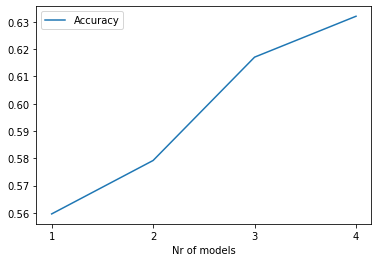

In [22]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [23]:
print("Accuracy: " + str(predict(models, x_test, y_testc)))

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

Accuracy: 0.6366


## Correlation between models

In [24]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


In [25]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 4/4 [00:00<00:00, 105.47it/s]


In [26]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
display(correlation_matrix_df)
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2,3
0,NaN,0.352279,0.522538,0.472872
1,0.352279,NaN,0.442518,0.430104
2,0.522538,0.442518,NaN,0.463742
3,0.472872,0.430104,0.463742,NaN


Average correlation: 0.4473420836417101
